### Imported the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

### Load the data

In [3]:
# import polars as pl
# df = pl.read_csv("../Data/Fraud.csv")
# df.head(5)

import dask.dataframe as dd
df = dd.read_csv("../Data/Fraud.csv")
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [16]:
print(type(df))

<class 'dask.dataframe.dask_expr._collection.DataFrame'>


In [15]:
print(df.shape)

(<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(6c6db57)).size() // 11, dtype=int64>, 11)


In [17]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 11 entries, step to isFlaggedFraud
dtypes: float64(5), int64(3), string(3)

In [19]:
# pdf = df.to_pandas()
pdf = df.compute()

In [20]:
pdf.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [21]:
print(type(pdf))

<class 'pandas.core.frame.DataFrame'>


### EDA

In [22]:
pdf.describe().astype(int)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179861,833883,855113,1100701,1224996,0,0
std,142,603858,2888242,2924048,3399180,3674128,0,0
min,1,0,0,0,0,0,0,0
25%,156,13389,0,0,0,0,0,0
50%,239,74871,14208,0,132705,214661,0,0
75%,335,208721,107315,144258,943036,1111909,0,0
max,743,92445516,59585040,49585040,356015889,356179278,1,1


In [23]:
pdf['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [27]:
pdf['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [28]:
pdf.isnull().sum().sum()

np.int64(0)

* No null values present in the data.

In [29]:
print(round(pdf['isFraud'].value_counts()[1]/ pdf.shape[0] * 100, 2))

0.13


#### Total count of Transaction Types

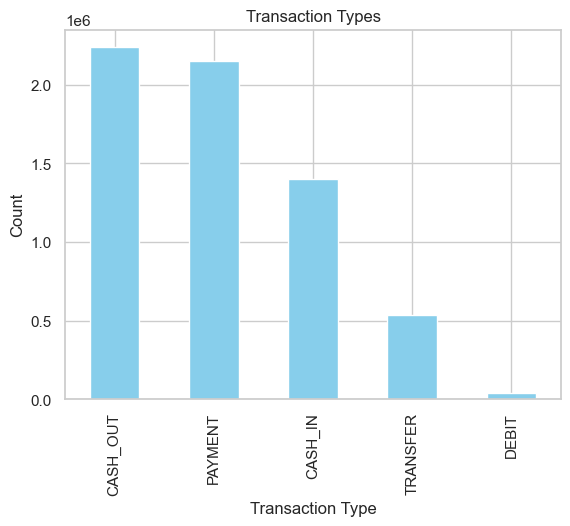

In [30]:
pdf['type'].value_counts().plot(kind='bar', title='Transaction Types', color='skyblue')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

#### Fraud Rate by Type

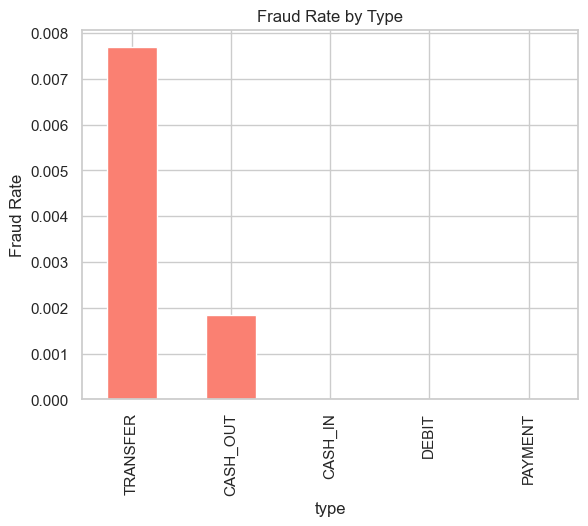

In [31]:
fraud_by_type = pdf.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', title='Fraud Rate by Type', color='Salmon')
plt.ylabel('Fraud Rate')
plt.show()

In [32]:
pdf['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

#### Transaction amount Distribution (log scale)

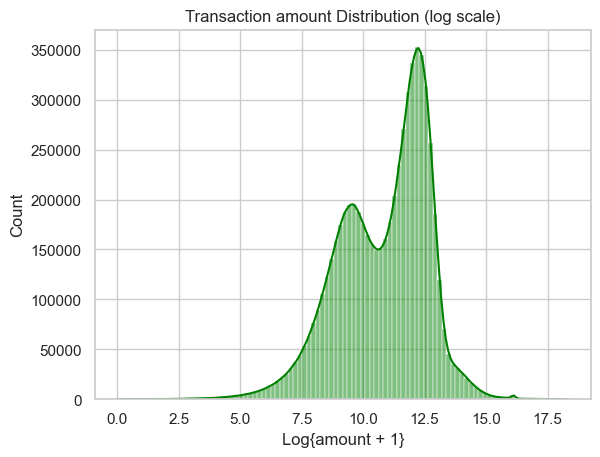

In [33]:
sns.histplot(np.log1p(pdf['amount']), bins=100, kde=True, color='green')
plt.title("Transaction amount Distribution (log scale)")
plt.xlabel("Log{amount + 1}")
plt.show()

#### Amount vs (including legit and Fraud) transaction (Filtered under 50k)

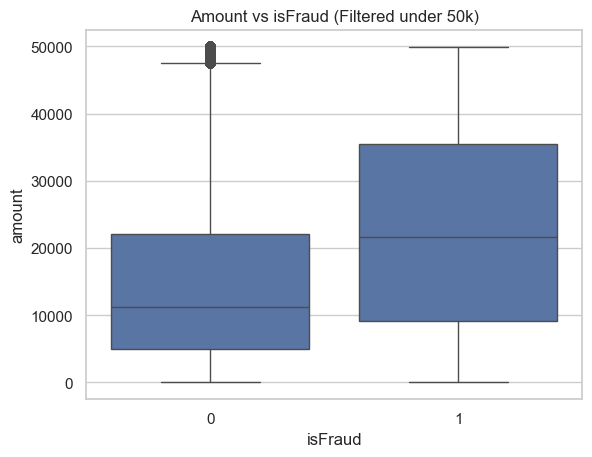

In [34]:
sns.boxplot(data=pdf[pdf['amount'] < 50000], x = "isFraud", y='amount')
plt.title("Amount vs isFraud (Filtered under 50k)")
plt.show()

In [35]:
pdf.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [36]:
pdf['balanceDiffOrig'] = pdf['oldbalanceOrg'] - pdf['newbalanceOrig']
pdf['balanceDiffDest'] = pdf['newbalanceDest'] - pdf['oldbalanceDest']

In [37]:
print((pdf['balanceDiffOrig'] < 0).sum())

1399253


In [38]:
print((pdf['balanceDiffDest'] < 0).sum())

1238864


#### Checking whether transaction depend on time-interval or not

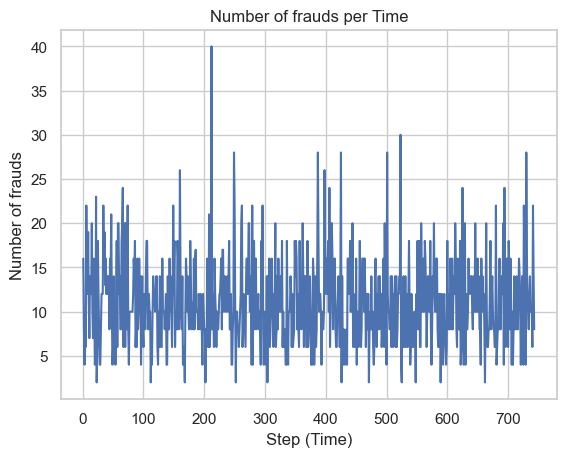

In [39]:
frauds_per_step = pdf[pdf['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.xlabel('Step (Time)')
plt.ylabel('Number of frauds')
plt.title('Number of frauds per Time')
plt.grid(True)
plt.show()

* Here, it shows that Fraud transaction are not depended on time or step, so we can remove this feature from model training.

In [40]:
pdf.drop(columns='step', inplace=True)

In [41]:
pdf.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [42]:
top_senders = pdf['nameOrig'].value_counts().head(10)
top_senders

nameOrig
C2098525306    3
C400299098     3
C1999539787    3
C1065307291    3
C545315117     3
C1976208114    3
C1784010646    3
C1530544995    3
C1902386530    3
C1677795071    3
Name: count, dtype: int64[pyarrow]

In [43]:
top_receivers = pdf['nameDest'].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64[pyarrow]

In [44]:
fraud_users = pdf[pdf['isFraud'] == 1]['nameOrig'].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
C1118430673    1
C749981943     1
C1334405552    1
C467632528     1
C1364127192    1
Name: count, dtype: int64[pyarrow]

In [45]:
fraud_types = pdf[pdf['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [46]:
fraud_types['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64[pyarrow]

#### Fraud Distribution in Transfer & Cash_Out

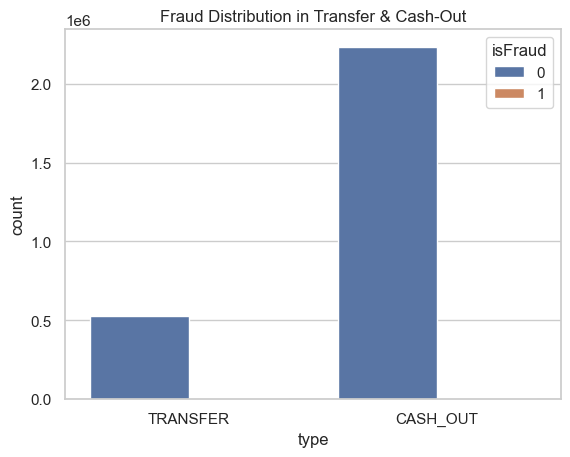

In [47]:
sns.countplot(data=fraud_types, x='type', hue='isFraud')
plt.title("Fraud Distribution in Transfer & Cash-Out")
plt.show()

* Here, the distribution shown for Tranfer and Cash-out types in Fraud Transaction, because this two types has more number of transactions taken place in the data.

In [48]:
pdf.columns

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'balanceDiffOrig', 'balanceDiffDest'],
      dtype='object')

#### Correlation between relevant features

In [49]:
corr = pdf[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


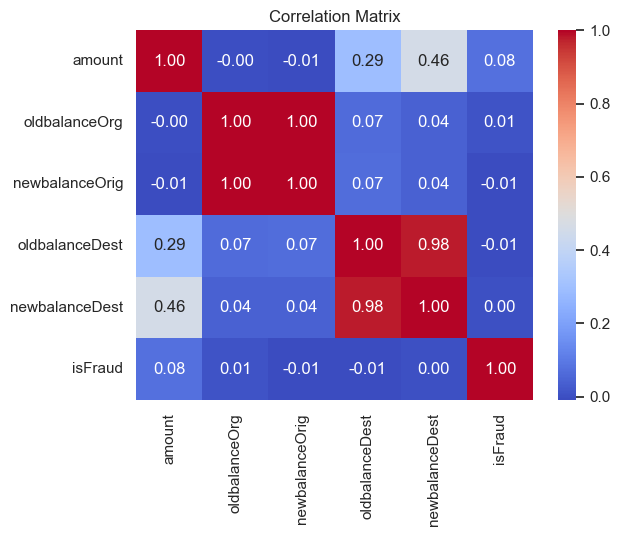

In [50]:
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

* Here, old_balance_origin has highly positive correlation with new_balance_Origin and old_balance_Dest has high positive correlation with new_balance_Dest.

In [51]:
zero_after_transfer = pdf[
    (pdf['oldbalanceOrg'] > 0) &
    (pdf['newbalanceOrig'] == 0) &
    (pdf['type'].isin(['TRANSFER', 'CASH_OUT']))
]

In [52]:
len(zero_after_transfer)

1188074

In [53]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


### Model Training

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.metrics as metrics

In [55]:
pdf.head(6)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0
5,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0,7817.71,0.0


In [56]:
df_model = pdf.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [57]:
cat = ['type']
num = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [58]:
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(drop='first'), cat)
    ],
    remainder='drop'
    )

In [61]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

### Logistic Regression

In [62]:
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [63]:
y_pred = pipeline.predict(X_test)

### Evaluation Metrics - Logistic Regression

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.95      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



* Here, accuracy is around 95% but precision is low for fraud transanction classification problem.

In [65]:
print(confusion_matrix(y_test, y_pred))

[[1805172  101150]
 [    139    2325]]


In [66]:
pipeline.score(X_test, y_test) * 100

94.6935381965291

#### AUC ROC - Logistic Regression

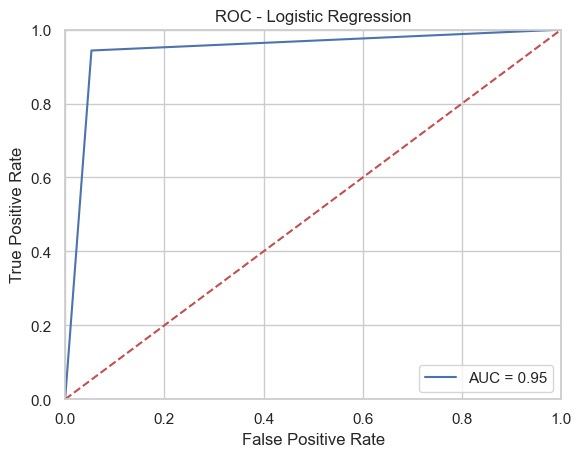

In [67]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

* The AUC score of Logistic Regression is approx 0.95.

### Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
pipeline_dt = Pipeline([
    ('prep', preprocessor),
    ('clf_dt', DecisionTreeClassifier(class_weight='balanced'))
])

In [69]:
pipeline_dt.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf_dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [70]:
y_pred_dt = pipeline_dt.predict(X_test)

### Evaluation Metrics - Decision Tree

In [71]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.90      0.87      0.89      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.93      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



In [72]:
print(confusion_matrix(y_test, y_pred_dt))

[[1906088     234]
 [    322    2142]]


In [73]:
pipeline_dt.score(X_test, y_test) * 100

99.97087153824474

#### AUC ROC - Decision Tree

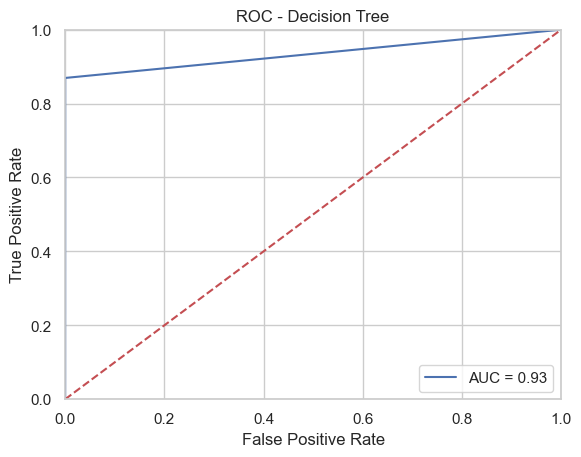

In [74]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4. Demonstrate the performance of the model by using best set of tools.
* Here, The AUC ROC score of Decision Tree is 0.93 is less than Logistic Regression
* But Precision of Decision Tree is better in comparison to Logistic Regression.

### 5. What are the key factors that predict fraudulent customer?

* The source of request is secured or not ?
* Is the name of organisation asking for money is legit or not ?
* Transaction history of vendors.

### 6. Do these factors make sense? If yes, How? If not, How not?

* With the help of Transaction history of vendors, we get the pattern in the balance history which will reveal the unusual activity.
* With Organisation name, it will help in checking whether the destination source is merchant's account or fake account.
* Based on the source type it will relates to whether the transaction channel is risky or not.

### 7. What kind of prevention should be adopted while company update its infrastructure?

* Use smart vertified apps only.
* Browse through secured websites.
* Use secured internet connections (USE VPN).
* Keep your mobile and laptop security updated.
* Don't respond to unsolicited calls/SMS/E-mails.
* If you feel like you have been tricked or security compromised, contact your bank immidiately.

### 8. Assuming these actions have been implemented, how would you determine if they work?

* Bank sending E-statements.
* Customers keeping a check of their account activity.
* Always keep a log of your payments.

### 1. Data cleaning including missing values, outliers and multi-collinearity.

1. Missing Values:
* Verified using df.isnull().sum() → dataset has no missing values, so no imputation was required.

2. Outliers:
* Minimum transaction amount is 0, which is valid but unusual; such zero-amount transactions were flagged for investigation (possible fraud or failed transactions).
* Distribution of amount was highly skewed, so log transformation/visualization was applied during EDA to handle scale issues.

3. Multicollinearity:
* Found very high correlation between:
oldbalanceOrg ↔ newbalanceOrig and
oldbalanceDest ↔ newbalanceDest
* This suggests redundancy since new balances are directly derived from old balances + transaction amount.
* To reduce multicollinearity, engineered features balanceDiffOrig and balanceDiffDest were introduced as cleaner indicators of money movement.


### 2. Describe your fraud detection model in elaboration.

I built a fraud detection model using the given transaction dataset, where the goal was to predict whether a transaction is fraudulent (isFraud).

1. Exploratory Data Analysis (EDA):

* Analyzed transaction types distribution to understand dataset composition.
* Computed fraud rate by type, identifying that fraud is concentrated in TRANSFER and CASH_OUT.
* Examined transaction amount distribution using log scale to handle skewness.
* Compared fraud vs. legitimate transactions under 50k, revealing unusual fraud activity patterns at lower values.
* Investigated time dependency with fraud vs. time distribution, confirming fraud occurrence patterns are not evenly spread.
* Explored fraud distribution in TRANSFER & CASH_OUT, the riskiest transaction types.
* Checked correlations among relevant features to detect multicollinearity.
* Flagged zero-amount after transaction cases, where accounts emptied suspiciously:

2. Features Used:

* Transaction attributes: type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, and the target isFraud.

Engineered features to capture hidden patterns:

* balanceDiffOrig = oldbalanceOrg - newbalanceOrig → represents how much balance actually moved out of the origin account.
* balanceDiffDest = newbalanceDest - oldbalanceDest → represents how much balance was added to the destination account.

These derived features improve fraud signal detection because fraudsters often manipulate balances in unusual ways.

3. Preprocessing:

* Label Encoding → categorical variable type converted into numeric form.
* StandardScaler → scaled numerical features to normalize transaction values and avoid model bias due to large amounts.

4. Models Applied & Evaluation:

* Trained Decision Tree and Logistic Regression classifiers.
* Compared them using AUC-ROC score (discrimination ability) and Precision (accuracy in predicting frauds).
* Decision Tree: AUC-ROC = 0.93, precision higher (better at minimizing false positives).
* Logistic Regression: Higher AUC-ROC than Decision Tree, but lower precision.

5. Insights:

* Logistic Regression is better for overall fraud vs. non-fraud separation (higher AUC).
* Decision Tree is better for catching actual fraud cases with fewer false alarms (higher precision).
* In fraud detection, precision is often more valuable, because wrongly flagging too many genuine customers harms trust.

### 3. How did you select variables to be included in the model?

* type → Fraud is more common in TRANSFER and CASH_OUT transactions than other types.
* amount → Large or unusual transaction amounts can indicate fraudulent activity.
* oldbalanceOrg → Starting balance of sender helps identify inconsistencies in outgoing transactions.
* newbalanceOrig → Balance after transaction highlights whether funds were unusually depleted.
* oldbalanceDest → Initial balance of receiver helps track whether destination accounts show normal or suspicious activity.
* newbalanceDest → Balance after transaction shows if funds are received consistently or abnormally.
* balanceDiffOrig → Captures the actual outflow from sender’s account (old – new balance).
* balanceDiffDest → Captures the actual inflow to receiver’s account (new – old balance).
* isFraud → Target variable indicating whether a transaction is fraudulent.

In [75]:
import joblib
joblib.dump(pipeline_dt, 'model.joblib')
# joblib.dump(preprocessor, 'preprocessor.joblib')

['model.joblib']

In [76]:
import pickle

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(pipeline_dt, f)

In [77]:
# Load model
with open("model.pkl", "rb") as f:
    model = pickle.load(f)